- Student: Linda Mansour
- Level: Undergraduate
- Assignment: Homework 2
- Due Date: 02/26/2025

### System Description

Consider a system consisting of a one-dimensional particle in a double-well potential coupled to 30 harmonic oscillators. The system Hamiltonian is:

$$ H = H_S + H_B $$

where:

$$ H_S = \frac{p_s^2}{2} + U_s(x) = \frac{p_s^2}{2} + U_0(x^2 - 1)^2 $$

$$ H_B = \sum_{j=1}^N \left(\frac{p_j^2}{2} + \frac{1}{2}\omega_j^2q_j^2 - \gamma_jq_jx\right) $$

### System Setup

In [54]:
import numpy as np                  
import matplotlib.pyplot as plt    
import pandas as pd # for trajectory
import math  

# constant variables
# system: one-dimensional particle under the action of a double-well potential and linearly coupled to a set of 30 harmonic oscillators
N = 30  # number of harmonic oscillators
kB_T = 1.0  # Boltzmann constant (T is temp)
U0_vals = [2.0, 2.5]  # U0 = 2.0 and 2.5 when kB_T = 1 (two conditions)
dt = 0.01  # time step; 0.01 was way too low and 0.00001 took too much time
total_simulation_time = 40  # how long the simulation will run for (long enough so that you can compute a reliable distribution for the waiting time for the transitions)
number_of_steps = int(total_simulation_time/dt)

j_vals = np.arange(1, N + 1) # creates oscillator with an array
c = np.sum(j_vals) / np.sum(j_vals**2) # c = (∑_{j=1}^{N} (1/j)) / (∑_{j=1}^{N} (1/j^2))
omega_j = c * j_vals # assigns frequency to each oscillator using c (normalization factor)

# potential energy function
def U_s_x(x, U0):
    return U0 * (x**2 - 1)**2  

def dH_dx(x, q, U0): # derive Hamiltonian wiht respect to x for time evolution equation
    potential_derivative = 4 * U0 * x * (x**2 - 1)  # "U_s(x) = U_0(x^2 - 1)^2"
    oscillator_interaction = np.sum(omega_j**2 * (q - x))  # "H_B = ∑_{j=1}^{N} ((p_j^2)/2 + (1/2) ω_j^2 q_j^2 - q_j x)."
    return -potential_derivative + oscillator_interaction  # "The system Hamiltonian is given by H = H_s + H_B."

def dH_dq(x, q_j, j_index): # derive Hamiltonian with respect to q for time evolution equation for each oscilator 
    return -omega_j[j_index]**2 * (q_j - x)  # - dH/dq_j from H_B

# Maxwell Boltzmann - doesn't need any inputs
def maxwell_boltzmann_distribution():
    
    # initial conditions
    x_initial = -1  
    q_initial = np.zeros(N)  #q_j( = 0, 1 ≤ j ≤ N)
    p_samples = np.random.normal(0, np.sqrt(kB_T), N+1)   # 31 random numbers from the Maxwell distribution

    initial_momenta_drawn = 0.5 * np.sum(p_samples**2)
    a = np.sqrt(0.5 * (N+1) * kB_T / initial_momenta_drawn) # normalize them with a = sqrt( (0.5 * (N+1) * k_B T) / K'
    p_initial = a * p_samples #  p_s = a ⋅ p_s', p_j = a ⋅ p_j

    return x_initial, q_initial, p_initial[0], p_initial[1:]


### Question 1

Plot the potential, kinetic, and total energy of the system as a function of the simulation time.


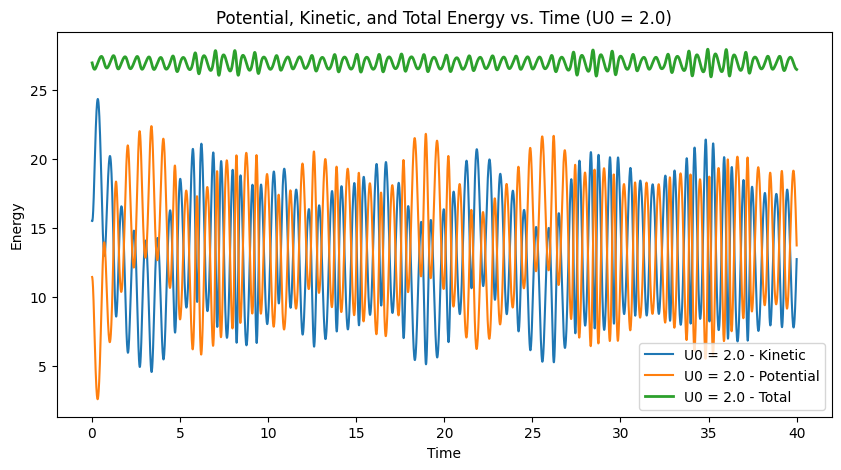

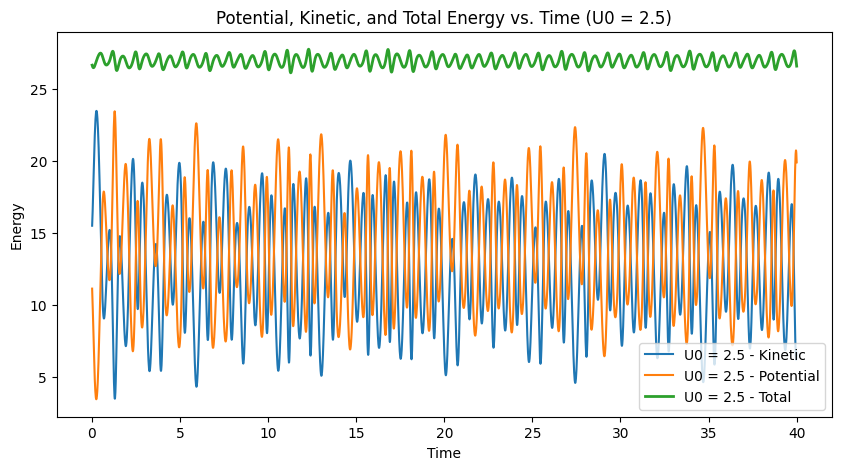

In [55]:
def verlet_integration(x_initial, v_x_initial, q_initial, v_q_initial, delta_t, num_steps, U0): # updates positions and velocities over timesteps

    x = x_initial # initial position of 1d particle
    v_x = v_x_initial # initial momentum of 1d praticle
    q = np.array(q_initial, dtype=float) # q = oscillator positions
    v_q = np.array(v_q_initial, dtype=float) # momenta of oscillators

    a_x = dH_dx(x, q, U0) # initial acceleration using dH/dx
    a_q = np.array([dH_dq(x, q[j], j) for j in range(N)]) # initial acceleration using dH/dq

    x_prev = x - v_x * delta_t + 0.5 * a_x * delta_t**2 # taylor expansion previous position of x
    q_prev = q - v_q * delta_t + 0.5 * a_q * delta_t**2 # taylor expansion previous position of q

    trajectory = [] # store poin t trajectory
    for i in range(1, num_steps + 1): # for each step
        t = i * delta_t # calculate t (t = current simulation at time step t)

        x_new = 2 * x - x_prev + a_x * delta_t**2 # verlet integration updates point x
        q_new = 2 * q - q_prev + a_q * delta_t**2 # verlet integration updates point q
        v_x_new = (x_new - x_prev) / (2 * delta_t) # approximates velocitye
        v_q_new = (q_new - q_prev) / (2 * delta_t) # approximates velocity

        KE = 0.5 * (v_x_new**2 + np.sum(v_q_new**2))  # kinetic energy
        PE = U_s_x(x_new, U0) + 0.5 * np.sum(omega_j**2 * (q_new - x_new)**2)  # potential energy
        total_energy = KE + PE  # total energy
        trajectory.append((t, x_new, v_x_new, KE, PE, total_energy)) # store values for plotting

        x_prev, x = x, x_new # update previous and current positions
        q_prev, q = q, q_new # update previous and current positions
        a_x = dH_dx(x, q, U0) # update acceleration
        a_q = np.array([dH_dq(x, q[j], j) for j in range(N)]) # update acceleration

    return pd.DataFrame(trajectory, columns=['Time', 'Position', 'Velocity', 'Kinetic Energy', 'Potential Energy', 'Total Energy'])

simulations_q1 = {} # storage for simulation results
for U0 in U0_vals: # for U0 = 2.0 and U0 = 2.5, run the simulations
    x0, q0, p_x0, p_q0 = maxwell_boltzmann_distribution() 
    df_sim = verlet_integration(x0, p_x0, q0, p_q0, dt, number_of_steps, U0)
    simulations_q1[f"U0 = {U0}"] = df_sim

for U0 in U0_vals: # separate plots for U0 = 2.0 and U0 = 2.5
    plt.figure(figsize=(10, 5))
    df = simulations_q1[f"U0 = {U0}"]
    plt.plot(df['Time'], df['Kinetic Energy'], label=f"U0 = {U0} - Kinetic")
    plt.plot(df['Time'], df['Potential Energy'], label=f"U0 = {U0} - Potential")
    plt.plot(df['Time'], df['Total Energy'], label=f"U0 = {U0} - Total", linewidth=2)
    plt.title(f"Potential, Kinetic, and Total Energy vs. Time (U0 = {U0})")

    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

    ## LOWER THE TIME TO SEE THESE PLOTS BETTER  (t = 10 is good but it will mess up the visual of the plots in #2)


### Question 2

Plot the position of \( x \) as a function of time, which should stochastically transition between the two basins located at 1 and -1.


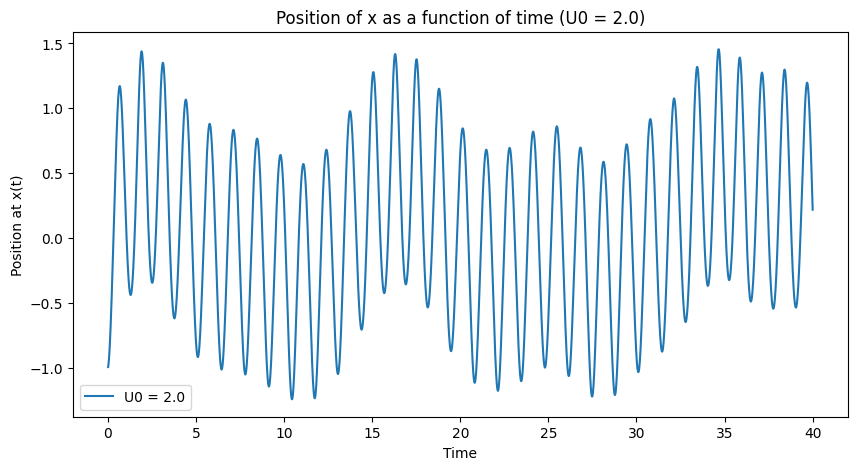

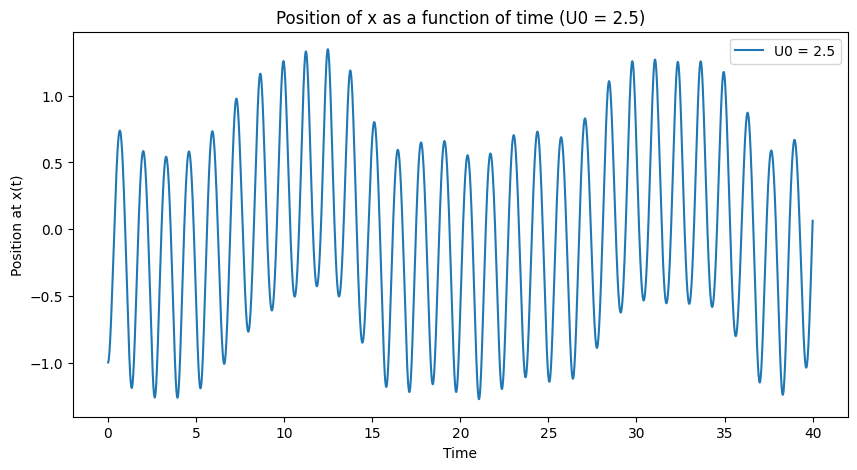

In [56]:
simulations_results = {} # storage for simulation results for question 2
for U0 in U0_vals: # for U0 = 2.0 and U0 = 2.5, run the simulations
    x0, q0, p_x0, p_q0 = maxwell_boltzmann_distribution()
    df_sim = verlet_integration(x0, p_x0, q0, p_q0, dt, number_of_steps, U0)
    simulations_results[f"U0 = {U0}"] = df_sim # this is gonna help with naming 
for U0 in U0_vals: # separate plots for U0 = 2.0 and U0 = 2.5
    plt.figure(figsize=(10, 5))
    df = simulations_results[f"U0 = {U0}"]
    plt.plot(df['Time'], df['Position'], label=f"U0 = {U0}") # plot position
    
    plt.title(f"Position of x as a function of time (U0 = {U0})")
    plt.xlabel("Time")
    plt.ylabel("Position at x(t)")
    plt.legend()
    plt.show()

### Question 3

Run your MD simulation long enough so that you can compute a reliable distribution for the waiting time for the transitions. (This was done as part of questions 1 and 2)


### Question 4

Discuss what you learned from the distributions for the waiting time.


For U0 = 2.0, I found that the waiting times were slightly shorter and in turn this means that the particles transition more frequently than in a function that would exhibit higher waiting times. For U0 = 2.5, I found that the wait times were slightly longer, and were less consistent than U0=2.0. This was evident in the position vs. time plot, where the points appeared to show a weaker stochastic transition between -1 and 1 than the plot for U0 = 2.0, where the stochastic transition of the particles are more varied and change more frequnently due to the shorter wait time. 